<a href="https://colab.research.google.com/github/jrojasquiroz/hppAI/blob/main/evacal/1_muestra_distribucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo con datos para toda la RMB.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. Muestreo por distribución por quintiles

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlparse
import geopandas as gpd
from shapely.geometry import Point
import re

In [6]:
import sys
from shapely import __version__ as shapely_version
import matplotlib

library_versions = {
    "python": sys.version,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "geopandas": gpd.__version__,
    "matplotlib": matplotlib.__version__,
    "requests": requests.__version__,
    "urllib.parse": 'N/A',  # Part of the Python standard library
    "shapely": shapely_version,
    "re": 'N/A'  # Part of the Python standard library
}

library_versions

{'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]',
 'pandas': '2.0.3',
 'numpy': '1.25.2',
 'geopandas': '0.13.2',
 'matplotlib': '3.7.1',
 'requests': '2.31.0',
 'urllib.parse': 'N/A',
 'shapely': '2.0.4',
 're': 'N/A'}

In [ ]:
rmb=pd.read_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/primera_ronda/v-rmb-abril24.xlsx', sheet_name='Sheet1')
len(rmb)

24688

Le voy a hacer un filtro de precios, dado que he visto casos con `precio_euros` 0, 1 y de hasta 1800.

In [ ]:
rmb=rmb[rmb['precio_euros']>10000]
len(rmb)

24688

Antes de elegir una muestra, voy a eliminar todas aquellos casos que no tienen un enlace válido. El método que voy a usar no es perfecto para los enlaces válidos (es decir, se puede colar algún inválido), pero sí para los inválidos (todos son enlaces que ya no funcionan).

In [ ]:
# Función para verificar si un enlace es válido
def verificar_enlace_valido(link):
    try:
        # Realizamos una solicitud HEAD al enlace
        response = requests.head(link, headers={'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36'})

        # Verificar si el código de estado comienza con '3'
        if str(response.status_code).startswith('3'):
            return 1  # Enlace inválido
        else:
            return 0  # Enlace válido
    except:
        return 1  # En caso de algún error al abrir el enlace, lo marcamos como inválido

# Aplicamos la función a la columna 'Link' y guardamos los resultados en una nueva columna 'invalido'
rmb['invalido'] = rmb['Link'].apply(verificar_enlace_valido) #Con corte al 13 de mayo

rmb.to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/cuarto_intento/rawdata/1-v-rmb-abril24-invalidos.xlsx', index=False)

Como he guardado el avance en `v-rmb-abril24-invalidos.xlsx`, vuelvo a llamar al archivo para no tener que repetir el proceso.

In [ ]:
rmb=pd.read_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/cuarto_intento/rawdata/1-v-rmb-abril24-invalidos.xlsx')
len(rmb)

24688

¿Cuántos son inválidos?

In [ ]:
len(rmb[rmb['invalido']==1])

57

Ahora el dataframe lo dejo sólo con las observaciones válidas.

In [ ]:
df=rmb[rmb['invalido']==0]
len(df)

24631

Ahora hago un filtro más: voy a quitar todas aquellas ofertas que presumiblemente están *ocupadas*, porque son las que suelen no tener fotografías.

Para futuras ocasiones <mark>puedo añadir 'ilegalmente', 'situación ocupacional', 'posesión', 'procedimiento judicial', 'judicialmente'</mark>.

In [ ]:
keywords = [
    'ocupado', 'piso ocupado', 'sin justo título', 'no admite visitas',
    'ocupa', 'okupa', 'no se puede ver interiormente', 'no se puede ver', 'con inquilinos'
]

# Función para detectar palabras clave en la descripción
def detect_keywords(description):
    description_lower = description.lower()
    for keyword in keywords:
        # Usar una expresión regular para detectar la palabra clave
        if re.search(r'\b' + re.escape(keyword) + r'\b', description_lower):
            return 1
    return 0

# Crear la nueva columna 'prob_sin_foto' usando la función anterior
df['prob_sin_foto'] = df['Description'].apply(detect_keywords)

<ipython-input-9-78dd05086781>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prob_sin_foto'] = df['Description'].apply(detect_keywords)


In [ ]:
len(df[df['prob_sin_foto']==1])

1879

Y procedo a explorar los quintiles de ingreso.

In [ ]:
df=df[df['prob_sin_foto']==0]
df['qprecio'] = pd.qcut(df['precio_euros'], 5, labels=False)

<ipython-input-11-14a15170a0ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['qprecio'] = pd.qcut(df['precio_euros'], 5, labels=False)


In [ ]:
len(df)

22752

Reviso la cantidad de casos por cada quintil.

In [ ]:
print(len(df[df['qprecio']==0]))
print(len(df[df['qprecio']==1]))
print(len(df[df['qprecio']==2]))
print(len(df[df['qprecio']==3]))
print(len(df[df['qprecio']==4]))

4599
4519
4574
4509
4551


Ahora voy a añadir el dataframe de municipios de España para que cada punto embeba el municipio al que pertenece.

In [ ]:
geomun=gpd.read_file('/content/drive/MyDrive/Datos/españa/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')

# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(df['Lon_X'], df['Lat_Y'])]
crs = 'epsg:4326'  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

In [ ]:
print(geomun.crs)
print(gdf_puntos.crs)

EPSG:32631
EPSG:32631


In [ ]:
print(geomun.columns.tolist())

['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE', 'NAMEUNIT', 'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry']


In [ ]:
gdf_rmb = gpd.sjoin(gdf_puntos, geomun[['NAMEUNIT','geometry']], how='inner', predicate='intersects')
gdf_rmb=gdf_rmb.drop(['geometry','index_right'],axis=1)

len(gdf_rmb)

22718

In [ ]:
22752-22718

34

Hay 34 observaciones menos que en `df` debido a que esas no tenían información de su ubicación.

In [ ]:
print(gdf_rmb.columns.tolist())

['ID', 'Title', 'Link', 'precio_euros', 'codigo_inmueble', 'Description', 'last_mod', 'dummy_indice', 'indice_alquiler', 'area', 'n_rooms', 'price_m2', 'n_baths', 'n_aseo', 'laundry', 'buhardilla', 'despacho', 'trastero', 'terrace', 'kwhm2_year', 'kgCO2m2_year', 'dummy_consum_EPC', 'dummy_emission_EPC', 'consum_A', 'consum_B', 'consum_C', 'consum_D', 'consum_E', 'consum_F', 'consum_G', 'emission_A', 'emission_B', 'emission_C', 'emission_D', 'emission_E', 'emission_F', 'emission_G', 'AC', 'parking', 'pool', 'lift', 'furniture', 'public_transp', 'barrio', 'codigo_inmueble_numero', 'Lat_Y', 'Lon_X', 'multifam', 'atico', 'duplex', 'estudio', 'loft', 'piso', 'triplex', 'invalido', 'prob_sin_foto', 'qprecio', 'NAMEUNIT']


In [ ]:
gdf_rmb.rename(columns={'NAMEUNIT':'MUN'}, inplace=True)

`gdf_rmb` es el base sobre la cual se calcula la muestra; es decir, el universo de nuestros datos. La exporto para tenerla a la mano.

In [ ]:
gdf_rmb.to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/cuarto_intento/rawdata/2-v-universo_rmb-abril24.xlsx', index=False)

Ahora voy a calcular una muestra sobre el total de `df`, pero quiero darle mayor peso a las observaciones de los quintiles más bajos debido a que la evaluación previa que he hecho (`tercer_intento` y `orden_tercer_intento`) me ha hecho darme cuenta que las peores características (*contemporaneidad*, *estado*, entre otras) están infrarepresentadas.

Este muestreo se hace por municipio (por eso el `groupby`), y se considera lo siguiente: Si el municipio tiene diez o menos observaciones, se mantienen todas (ya no es necesaria una muestra); si tiene más de diez observaciones: siempre respetar el muestreo estratificado con base en `porcentajes_quintiles`, pero considerando que como mínimo haya una observación por quintil.

Vale la pena tener en cuenta que los valores de `porcentajes_quintiles` los he ido ajustando hasta tener una muestra de aproximadamente 3000 observaciones. Dado el tiempo que resta del Seminario, consideramos necesario no sobrepasar ese límite.

In [ ]:
# Define los porcentajes deseados para cada quintil
porcentajes_quintiles = [0.04, 0.035, 0.02, 0.015, 0.0125]

def muestreo_estratificado_por_municipio(df):
    muestra_estratificada = pd.DataFrame()
    for municipio, df_municipio in df.groupby('MUN'):
        if len(df_municipio) <= 10:
            # Si el municipio tiene 10 o menos observaciones, se agregan todas al DataFrame de muestra
            muestra_estratificada = pd.concat([muestra_estratificada, df_municipio])
        else:
            # Calcula los quintiles para el municipio actual
            df_municipio['qprecio_municipio'] = pd.qcut(df_municipio['precio_euros'], 5, labels=False, duplicates='drop')
            # Calcula el tamaño mínimo de muestra deseado para cada quintil dentro del municipio (1 observación por quintil)
            tamano_muestra_minimo = [1] * 5
            # Calcula el tamaño de muestra deseado para cada quintil dentro del municipio
            tamano_muestra_por_quintil_municipio = [
                max(tamano_muestra_minimo[q], int(len(df_municipio) * p)) for q, p in enumerate(porcentajes_quintiles)]
            for quintil, tamano_muestra in zip(range(5), tamano_muestra_por_quintil_municipio):
                # Filtra el DataFrame del municipio para el quintil actual
                df_quintil = df_municipio[df_municipio['qprecio_municipio'] == quintil]
                # Calcula el tamaño de muestra real para este quintil dentro del municipio
                tamano_quintil_real = len(df_quintil)
                # Ajusta el tamaño de muestra si es mayor que el tamaño real del quintil dentro del municipio
                tamano_muestra_actual = min(tamano_muestra, tamano_quintil_real)
                # Muestrea el quintil dentro del municipio según el tamaño deseado
                muestra_quintil = df_quintil.sample(tamano_muestra_actual, random_state=42)
                # Agrega la muestra del quintil al DataFrame final
                muestra_estratificada = pd.concat([muestra_estratificada, muestra_quintil])
            # Agrega las observaciones restantes (si las hay) para asegurar que cada quintil tenga al menos una observación
            for quintil in range(5):
                df_quintil = df_municipio[df_municipio['qprecio_municipio'] == quintil]
                if len(df_quintil) > tamano_muestra_por_quintil_municipio[quintil]:
                    muestra_estratificada = pd.concat([muestra_estratificada, df_quintil.sample(1)])
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a tu DataFrame
muestra_rmb = muestreo_estratificado_por_municipio(gdf_rmb)

Reviso cuántas observaciones hay por quintil en la muestra.

In [ ]:
print(len(muestra_rmb[muestra_rmb['qprecio']==0]))
print(len(muestra_rmb[muestra_rmb['qprecio']==1]))
print(len(muestra_rmb[muestra_rmb['qprecio']==2]))
print(len(muestra_rmb[muestra_rmb['qprecio']==3]))
print(len(muestra_rmb[muestra_rmb['qprecio']==4]))

print(len(muestra_rmb))

981
869
666
545
391
3452


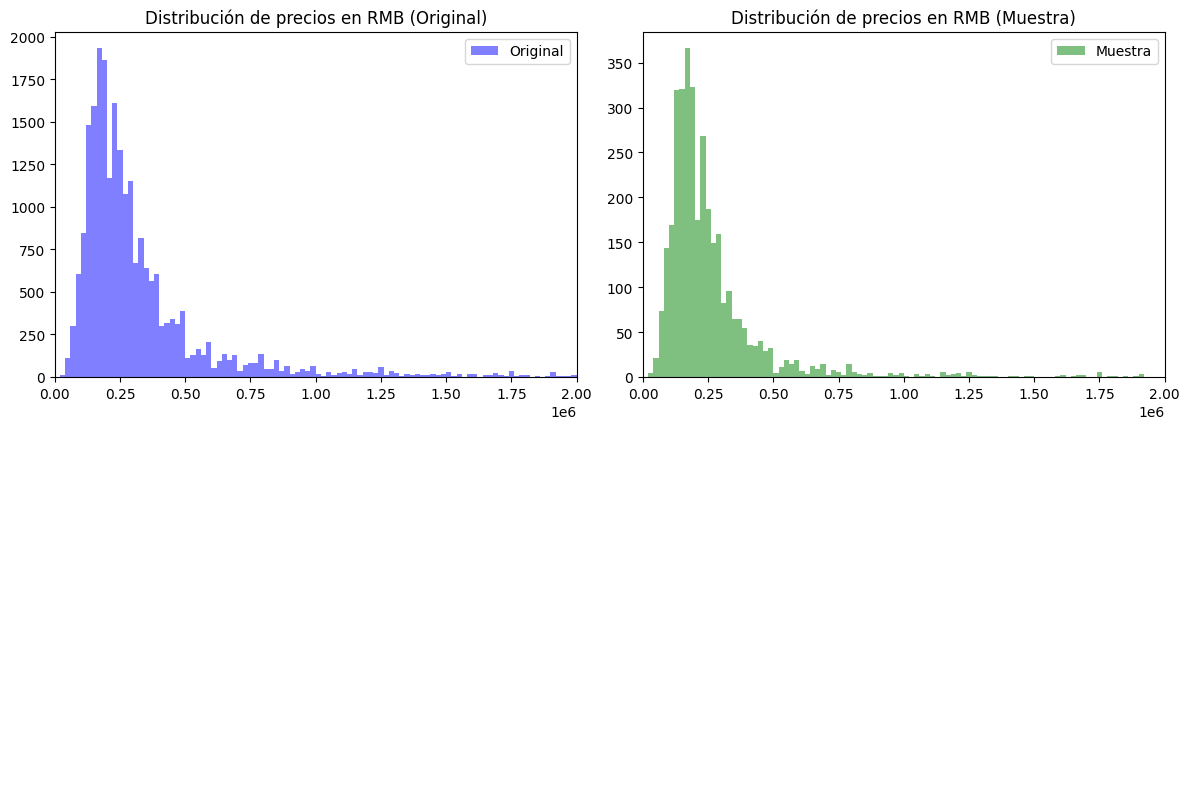

In [ ]:
# Crear subgráficos para mostrar los histogramas
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Definir los límites y la separación del eje x
x_min = 0
x_max = 2000000
bin_width = 20000
num_bins = int((x_max - x_min) / bin_width)

# Histograma de los datos originales de amb
axs[0, 0].hist(df['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='blue', alpha=0.5, label='Original')
axs[0, 0].set_title('Distribución de precios en RMB (Original)')
axs[0, 0].legend()

# Histograma de los datos de la muestra de amb
axs[0, 1].hist(muestra_rmb['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='green', alpha=0.5, label='Muestra')
axs[0, 1].set_title('Distribución de precios en RMB (Muestra)')
axs[0, 1].legend()

# Eliminar los subgráficos sobrantes
axs[1, 0].axis('off')
axs[1, 1].axis('off')

# Ajustar los límites del eje x
for ax in axs.flat:
    ax.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

Inicialmente, conversamos con Carlos sobre la posibilidad de incluir pisos de Madrid. <mark>Me parece necesario que en este caso sólo tengamos evaluaciones sobre la RMB</mark> debido a dos motivos:
1. Calidad arquitectónica no tendría por qué cambiar drásticamente de una ciudad hacia otra.
2. Para mantener registro histórico de evaluación (2020, 2023, 2024).

Exporto para luego hacer reparto por estudiante.

In [ ]:
muestra_rmb.to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/evacal/cuarto_intento/rawdata/3-v-muestra_rmb-abril24.xlsx', index=False)